In [6]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import omnilearn as learn
from omnilearn import models
from omnilearn import util
from omnilearn.op.analysis import Run_Manager

from sklearn.decomposition import PCA
import sklearn.datasets

from src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
full_table = {}

In [14]:
save_figure_kwargs = dict(
#     root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\supplement',
    root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\neurips',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.device = 'cuda:1'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {n:f'C{n}' for n in range(10)}
info.group_names = {1:'Baseline', 0: 'Structural', 3:'Ladder', 2:'Adaptive', }

preset_figure_info(info)
print(info)

t{fsize, cut, device, results_name, small_font_size, medium_font_size, large_font_size, colors, group_names}


In [15]:
raw = '''AE	3ds_ae0_e-c12_d-c12_mish_210125-050038	celeba_ae0_e-c16_d-c16_mish_210125-132401	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928
VAE1	3ds_vae1_e-c12_d-c12_mish_210125-140254	celeba_vae1_e-c16_d-c16_mish_210125-132401	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340
VAE2	3ds_vae2_e-c12_d-c12_mish_210125-140255	celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340
VAE4	3ds_vae4_e-c12_d-c12_mish_210125-140302	celeba_vae4_e-c16_d-c16_mish-lrp0004_210201-101817	toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852
VAE8	3ds_vae8_e-c12_d-c12_mish_210125-140550		toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853
WAE10	3ds_wae10_e-c12_d-c12_mish_210125-140253		toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340
WAE100	3ds_wae100_e-c12_d-c12_mish_210125-221143		toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340
WAE1000	3ds_wae1000_e-c12_d-c12_mish_210125-221142		toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339
AE S2	3ds_ae_e-c12_d-s2_mish_210131-150237		toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829
AE S2 nosplit	3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234		toy_ae_e-c12_d-s2_nosplit-mish_210131-150234	sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	real_ae_e-c12_d-s2_nosplit-mish_210131-150234
AE S3	3ds_ae_e-c12_d-s3_mish_210201-021841		toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829
AE S3 nosplit	3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234		toy_ae_e-c12_d-s3_nosplit-mish_210131-150236	sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	real_ae_e-c12_d-s3_nosplit-mish_210131-150234
AE S4	3ds_ae0_e-c12_d-s4_mish_210125-140253		toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339
AE S4 nosplit	3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234		toy_ae_e-c12_d-s4_nosplit-mish_210131-150235	sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	real_ae_e-c12_d-s4_nosplit-mish_210131-150234
AE S6	3ds_ae0_e-c12_d-s6_mish_210125-140253		toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339
AE S6 nosplit	3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234		toy_ae_e-c12_d-s6_nosplit-mish_210131-150236	sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	real_ae_e-c12_d-s6_nosplit-mish_210131-150236
AE S12	3ds_ae0_e-c12_d-s12_mish_210125-050335	celeba_ae0_e-c16_d-s16_mish_210125-132401	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish_210127-231831
AE S12 nosplit	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851
VAE1 L2	3ds_vae1_e-l2_d-l2_mish_210131-150235		toy_vae1_e-l2_d-l2_mish_210131-150234	sim_vae1_e-l2_d-l2_mish_210131-150238	real_vae1_e-l2_d-l2_mish_210131-150240
VAE1 L3	3ds_vae1_e-l3_d-l3_mish_210131-150235		toy_vae1_e-l3_d-l3_mish_210131-150234	sim_vae1_e-l3_d-l3_mish_210131-150236	real_vae1_e-l3_d-l3_mish_210131-150236
VAE1 L4	3ds_vae1_e-l4_d-l4_mish_210125-134914		toy_vae1_e-l4_d-l4_mish_210131-150235	sim_vae1_e-l4_d-l4_mish_210127-231449	real_vae1_e-l4_d-l4_mish_210131-150236
VAE1 L6	3ds_vae1_e-l6_d-l6_mish_210125-140021		toy_vae1_e-l6_d-l6_mish_210131-150235	sim_vae1_e-l6_d-l6_mish_210127-231447	real_vae1_e-l6_d-l6_mish_210131-150236
VAE1 L12	3ds_vae1_e-l12_d-l12_mish_210125-140249	celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847'''

model_tbl = [row.split('\t') for row in raw.split('\n')]
headers = ['Name', '3D-Shapes', 'CelebA', 'MPI3D Toy', 'MPI3D Sim', 'MPI3D Real']
dataset_names = headers[1:]
all_model_names = {ds:{} for ds in dataset_names}
for title, *names in model_tbl:
    for path, ds in zip(names, dataset_names):
        if path is not None and len(path):
            all_model_names[ds][title] = path
print(tabulate(model_tbl, headers=headers))
len(model_tbl)

Name            3D-Shapes                                      CelebA                                              MPI3D Toy                                      MPI3D Sim                                      MPI3D Real
--------------  ---------------------------------------------  --------------------------------------------------  ---------------------------------------------  ---------------------------------------------  ----------------------------------------------
AE              3ds_ae0_e-c12_d-c12_mish_210125-050038         celeba_ae0_e-c16_d-c16_mish_210125-132401           toy_ae_e-c12_d-c12_mish_210125-222234          sim_ae_e-c12_d-c12_mish_210126-035850          real_ae_e-c12_d-c12_mish_210126-035928
VAE1            3ds_vae1_e-c12_d-c12_mish_210125-140254        celeba_vae1_e-c16_d-c16_mish_210125-132401          toy_vae1_e-c12_d-c12_mish_210126-122537        sim_vae1_e-c12_d-c12_mish_210126-123641        real_vae1_e-c12_d-c12_mish_210126-123340
VAE2            3ds_vae2_e

23

In [16]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
device = 'cuda'

In [17]:
base_codes = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'S2', 'AE S3':'S3', 'AE S4':'S4', 'AE S6':'S6', 'AE S12':'S12', 
               'VAE1 L2':'L2', 'VAE1 L3':'L3', 'VAE1 L4':'L4', 'VAE1 L6':'L6', 'VAE1 L12':'L12', 
               'AE S2 nosplit':'S2n', 'AE S3 nosplit':'S3n', 'AE S4 nosplit':'S4n', 'AE S6 nosplit':'S6n', 'AE S12 nosplit':'S12n', 
              }
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'SAE-2', 'AE S3':'SAE-3', 'AE S4':'SAE-4', 'AE S6':'SAE-6', 'AE S12':'SAE-12', 
               'VAE1 L2':'VLAE-2', 'VAE1 L3':'VLAE-3', 'VAE1 L4':'VLAE-4', 'VAE1 L6':'VLAE-6', 'VAE1 L12':'VLAE-12', 
               'AE S2 nosplit':'AdaAE-2', 'AE S3 nosplit':'AdaAE-3', 'AE S4 nosplit':'AdaAE-4', 'AE S6 nosplit':'AdaAE-6', 'AE S12 nosplit':'AdaAE-12', 
              }
title_order_base = ['AE S12', 'AE S6', 'AE S4', 'AE S3', 'AE S2', 
               'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2',
               'AE S12 nosplit', 'AE S6 nosplit', 'AE S4 nosplit', 'AE S3 nosplit', 'AE S2 nosplit',
               'AE', 'VAE1', 'VAE2', 'VAE4', 'VAE8', 'WAE10', 'WAE100', 'WAE1000',
              ]

mytitles = {}

In [18]:
ds = 'CelebA'
dscode = 'celeb'

mytitles = {k:v.replace('12', '16') for k,v in base_titles.items()}
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE1 L12':'VLAE-16', 'AE S12 nosplit': 'AdaAE-16', 'AE S12': 'SAE-16'}

In [8]:
ds = '3D-Shapes'
dscode = '3ds'

mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [35]:
ds = 'MPI3D Sim'
dscode = 'sim'

mytitles = {'AE S6 nosplit': None, 'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,}
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [58]:
ds = 'MPI3D Toy'
dscode = 'toy'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [83]:
ds = 'MPI3D Real'
dscode = 'real'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }
mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,  'AE S2 nosplit':None, 'AE S3 nosplit':None, 'AE S4 nosplit':None, 'AE S6 nosplit':None, }

In [19]:
groups_idx = {'AE':1, 'VAE1':1, 'VAE2':1, 'VAE4':1, 'VAE8':1, 'WAE10':1, 'WAE100':1, 'WAE1000':1, 
          'AE S2':0, 'AE S3':0, 'AE S4':0, 'AE S6':0, 'AE S12':0, 
          'VAE1 L2':3, 'VAE1 L3':3, 'VAE1 L4':3, 'VAE1 L6':3, 'VAE1 L12':3, 
          'AE S2 nosplit':2, 'AE S3 nosplit':2, 'AE S4 nosplit':2, 'AE S6 nosplit':2, 'AE S12 nosplit':2}



titles = base_titles.copy()
titles.update(mytitles)

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[k] is not None}

if ds == '3D-Shapes':
    model_names['AE S12'] = '3ds_ae_e-c12_d-s12_mish-seed5_210131-150235'

len(model_names), model_names.keys()

(6, dict_keys(['AE', 'VAE1', 'VAE2', 'AE S12', 'AE S12 nosplit', 'VAE1 L12']))

In [20]:
include_group_hyb = True 

In [21]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)
run_idents = {r.ident:r for r in runs}
title_order = [t for t in title_order_base if t in run_idents]

runs.map(lambda run: run.get_records())
runs.load_results('metrics', safe=True, load_kwargs={'device':device});
runs.load_results('final-hyb', safe=True, load_kwargs={'device':device});
runs.load_results(info.cut, load_kwargs={'device':device});

def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idx[run.ident]
    run.title = titles[run.ident]
    run.code = base_codes[run.ident]
runs.map(_load_info);


def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_results(info.cut)
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if include_group_hyb and run.has_results('final-hyb'):
        strc = run.get_results('final-hyb')
        print(f'using hyb-grp for {run}')
        run.stats['hyb_group_fid'] = strc['hyb-grp_fid']
    
    if 'hyb_group_fid' in run.stats:
        run.stats['old_hybrid_fid'] = run.stats['hybrid_fid']
        run.stats['hybrid_fid'] = run.stats['hyb_group_fid']
    
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
    
    if run.has_results('metrics'):
    
        met = run.get_results('metrics')
        if not hasattr(run, 'data'):
            run.data = util.adict()
        if 'results' in met:
            if 'IRS' in met['results']:
                run.data['IRS'] = met['results']['IRS']['IRS_matrix']
            if 'UnsupervisedMetrics' in met['results']:
                run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
            if 'SAP' in met['results']:
                run.data['SAP'] = met['results']['SAP']['SAP_matrix']
            if 'DCI' in met['results']:
                run.data['DCI'] = met['results']['DCI']['importance_matrix']
            if 'LatentResponses' in met['results']:
                run.data['Response'] = met['results']['LatentResponses']['response_mat']
                if 'factor_responses' in met['results']['LatentResponses']:
                    run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
        
        if 'scores' in met:
            if 'IRS' in met['scores']:
                run.stats['IRS'] = met['scores']['IRS']['avg_score']
            if 'DCI' in met['scores']:
                run.stats['DCI'] = met['scores']['DCI']['disentanglement']
            if 'DCI' in met['scores']:
                run.stats['DCI-c'] = met['scores']['DCI']['completeness']
            if 'SAP' in met['scores']:
                run.stats['SAP'] = met['scores']['SAP']['SAP_score']
            if 'MIG' in met['scores']:
                run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
            if 'ModularityExplicitness' in met['scores']:
                run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
#             if 'LatentResponses' in met['scores'] and 'disentanglement' in met['scores']['LatentResponses']:
#                 run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
            if 'FactorResponse' in run.data:
                f = run.data['FactorResponse'].min(1)[0].max(-1)[0].clone()
                cds = f.max(0)[0].sum().div(f.sum()).sub(1/f.size(0)).div((f.size(0)-1)/f.size(0))
                ccs = f.max(1)[0].sum().div(f.sum()).sub(1/f.size(1)).div((f.size(1)-1)/f.size(1))
                run.stats['CDS'] = cds.item()
                run.stats['CCS'] = ccs.item()
            if 'Fairness' in met['scores']:
                run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']


    
runs.map(_load_fid);

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

celeba_ae0_e-c16_d-c16_mish_210125-132401 failed
celeba_vae1_e-c16_d-c16_mish_210125-132401 failed
celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 151, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\runs.py", line 396, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\loading.py", line 52, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Anacond

celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401 failed
celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 151, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\runs.py", line 396, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\loading.py", line 52, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Anacond

  0%|          | 0/6 [00:00<?, ?it/s]

celeba_ae0_e-c16_d-c16_mish_210125-132401 failed
celeba_vae1_e-c16_d-c16_mish_210125-132401 failed
celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 151, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\runs.py", line 396, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\loading.py", line 52, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Anacond

celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401 failed
celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 151, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\analysis.py", line 179, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\runs.py", line 396, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\omnilearn\op\loading.py", line 52, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Anacond

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

using hyb-grp for celeba_ae0_e-c16_d-s16_mish_210125-132401


In [22]:
run = runs[1]
run

INLINE_TIMED_SAE_RUN:celeba_vae1_e-c16_d-c16_mish_210125-132401

In [23]:
# fig, ax = plt.subplots(figsize=info.fsize)

# objs = []
# texts = []
# tps = set()
# for r in runs:
#     objs.append(plt.scatter(r.stats.rec_loss, r.stats.rec_fid, color=info.colors[r.group]))
#     texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.code, horizontalalignment='center',
#       verticalalignment='center',))
#     tps.add(r.group)

# legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
# plt.legend(handles=legend_elements, title='Architecture')
# plt.xlabel('Reconstruction Loss')
# plt.ylabel('Reconstruction FID Score')
# plt.title(f'{info.title} Reconstruction Quality')
# # plt.xlim(left=6370)
# # plt.ylim(bottom=0)
# plt.tight_layout()
# # adjust_text(texts, #force_text=(0.1,0.1)
# #             #force_text=(0.1,0.25),
# #             add_objects=objs,
# #            )
# pass
# util.save_figure(f'{dscode}_rec_quality', **save_figure_kwargs)

<IPython.core.display.Javascript object>


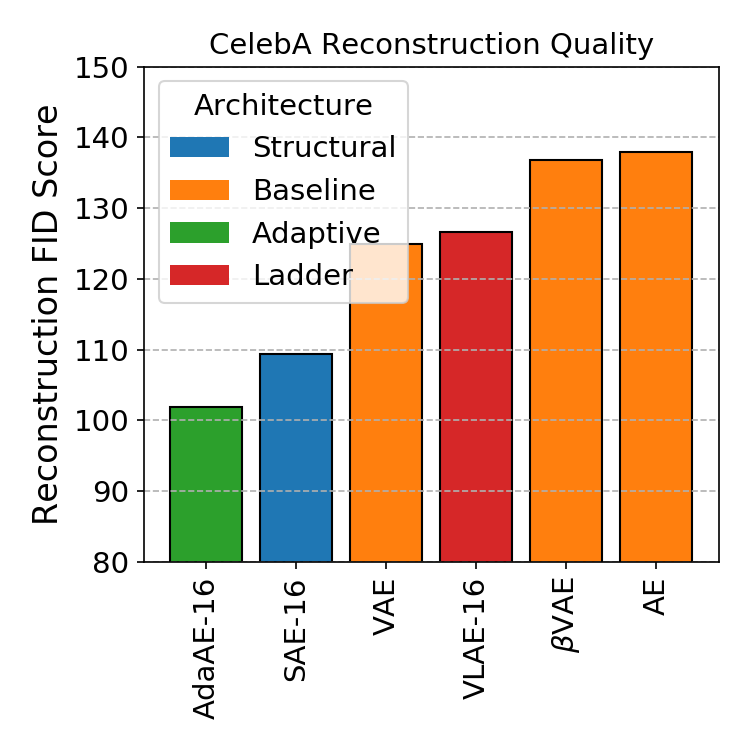

In [24]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
tps = set()
x = np.arange(len(title_order))

order = [x[1] for x in sorted((r.stats.rec_fid, r.ident) for r in runs)]
for i,t in enumerate(order):
    r = run_idents[t]
    s = r.stats.rec_fid
    c = info.colors[r.group]
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
    tps.add(r.group)
plt.xticks(x, [titles[t] for t in order], rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
# legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.ylabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if dscode == 'celeb':
    plt.ylim(80,150)
elif dscode in {'3ds', 'toy'}:
    plt.ylim(0,50)
elif dscode == 'real':
    plt.ylim(0,70)
# else:
#     plt.ylim(0,100)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
# util.save_figure(f'{dscode}_rec-fid', **save_figure_kwargs)
pass

In [15]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid if 'hyb_group_fid' not in r.stats else r.stats.hyb_group_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)
#     if 'hyb_group_fid' in r.stats:
#         scores.append(r.stats.hyb_group_fid)
#         groups.append(r.group)
#         typs.append('group')
#         names.append(r.title)
        

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else ('**' if t=='group' else 'oo')) for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

23

<IPython.core.display.Javascript object>


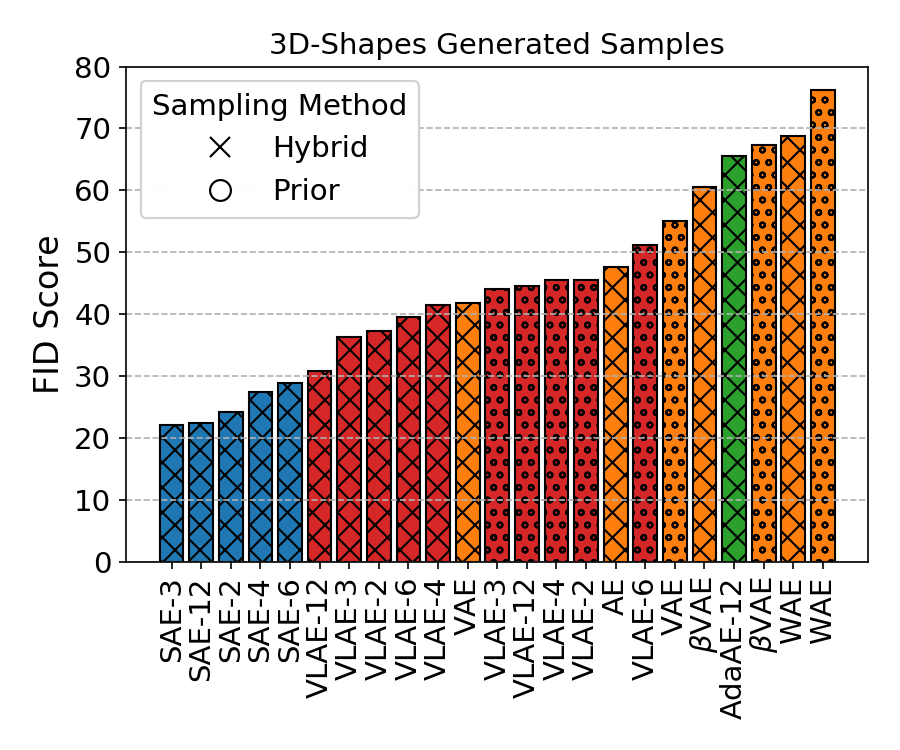

Figure 3ds_gen_tall saved as {'pdf', 'png'}


In [15]:
tall = True
if tall:
    fig, ax = plt.subplots(figsize=(6,5))
else:
    fig, ax = plt.subplots(figsize=(7,4))
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(groups)]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Hybrid'), 
                    mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
                          markersize=10, label='Prior')]
legend_titles = ['Hybrid', 'Prior']
if 'group' in typs:
    
    strctural = 'Strc-Hybrid'
    
    legend_elements1.insert(0, mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label=strctural))
    legend_titles.insert(0, strctural)
legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
elif dscode =='3ds':
    plt.ylim(0,80)
elif dscode == 'toy':
    plt.ylim(0,60)
elif dscode == 'sim':
    plt.ylim(0,100)
elif dscode == 'real':
    plt.ylim(0,90)
else:
    pass
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, legend_titles, loc=2, title='Sampling Method')
ax.add_artist(legend1, )
# ax.add_artist(legend)
plt.tight_layout()
aden = ''
# aden = 'grp' if include_group_hyb else ''
shape = 'tall' if tall else 'wide'
util.save_figure(f'{dscode}_gen{aden}_{shape}', **save_figure_kwargs)
pass

In [24]:
run.results[info.cut].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [11]:
title_order

['AE S12', 'VAE1 L12', 'AE S12 nosplit', 'AE', 'VAE1', 'VAE2']

In [12]:
run.stats.keys()

odict_keys(['rec_loss', 'rec_fid', 'hybrid_fid', 'hyb_group_fid', 'old_hybrid_fid'])

In [12]:
picks = ['CDS', 'CCS', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp', 'DCI-c']


In [13]:
if dscode not in full_table:
    dinfo = {}
    full_table[dscode] = dinfo
    for pick in picks:
        pinfo = {}
        dinfo[pick] = {t:run_idents[t].stats[pick] for t in title_order}
full_table.keys()

KeyError: 'CDS'

<IPython.core.display.Javascript object>


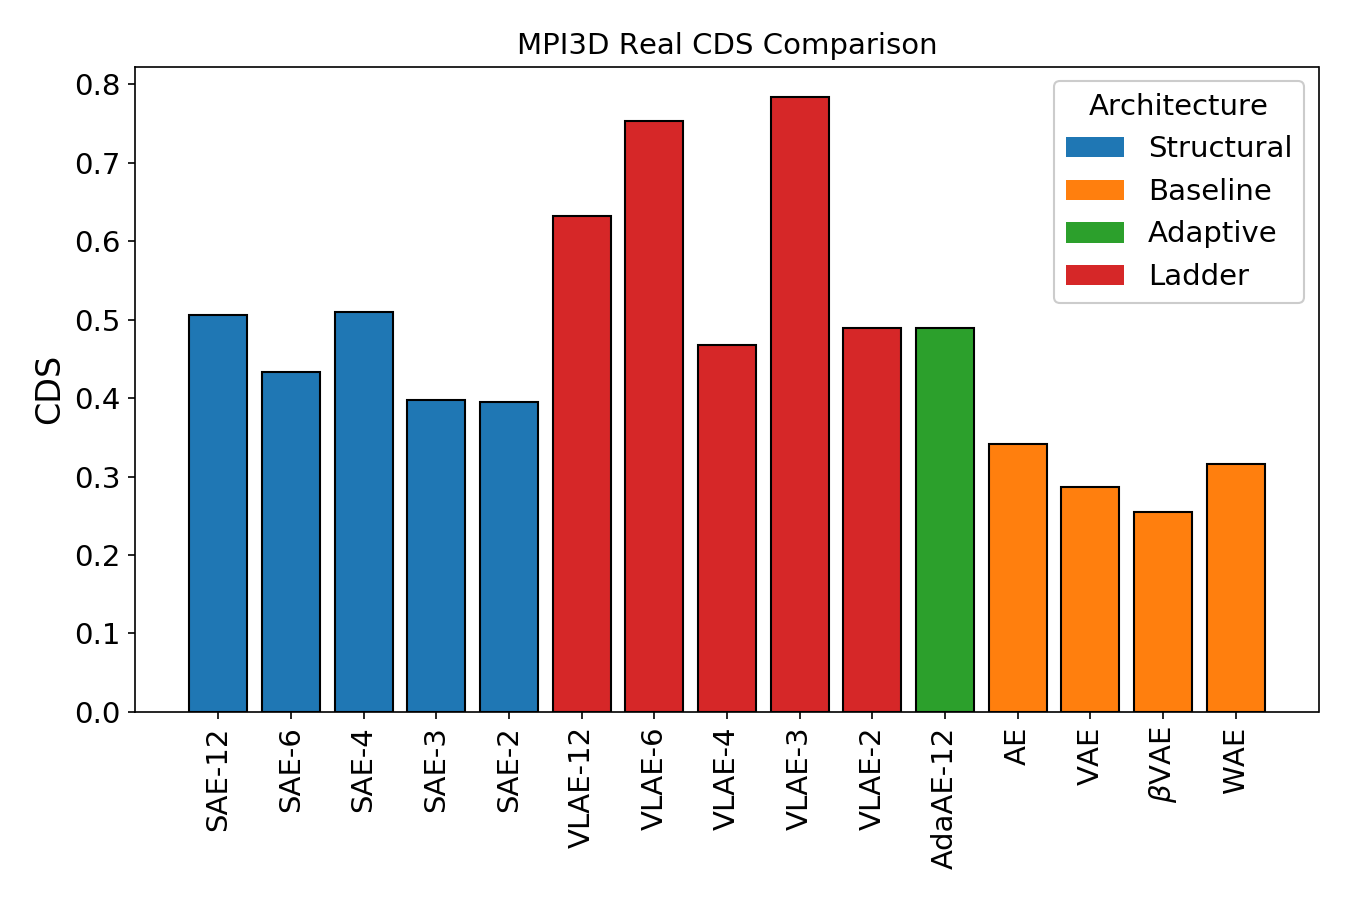

<IPython.core.display.Javascript object>


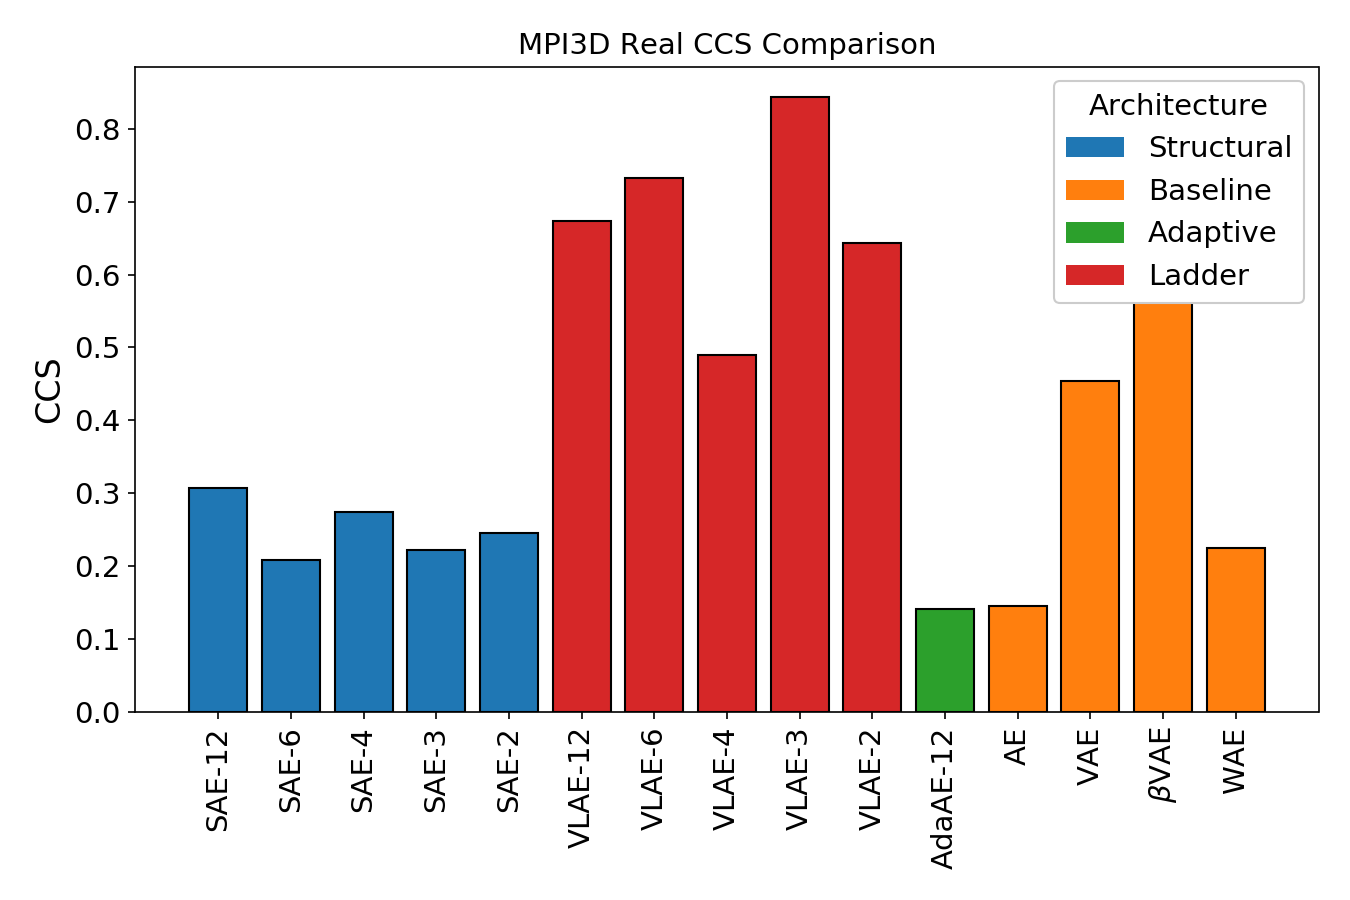

<IPython.core.display.Javascript object>


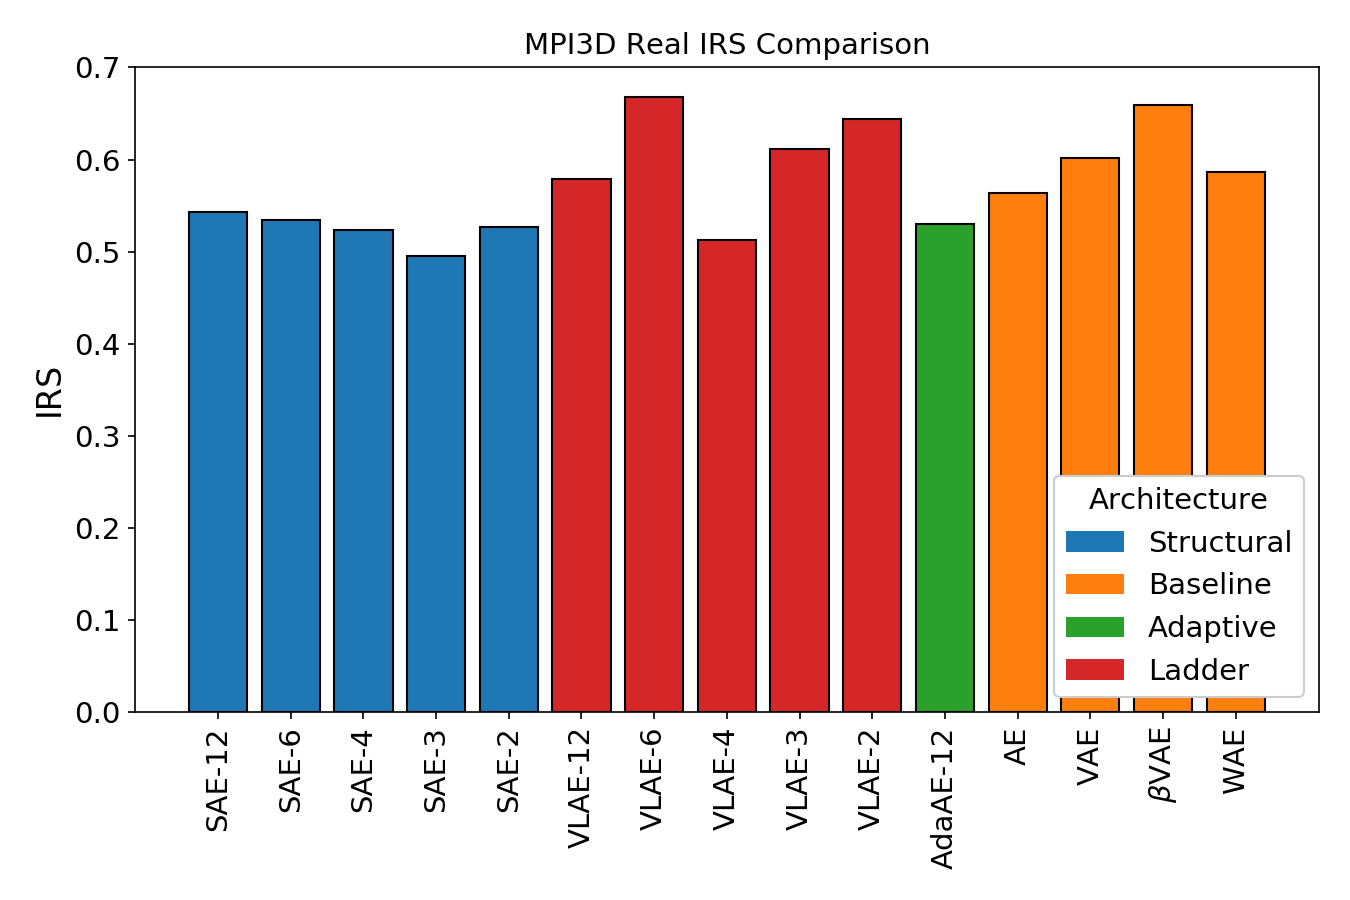

<IPython.core.display.Javascript object>


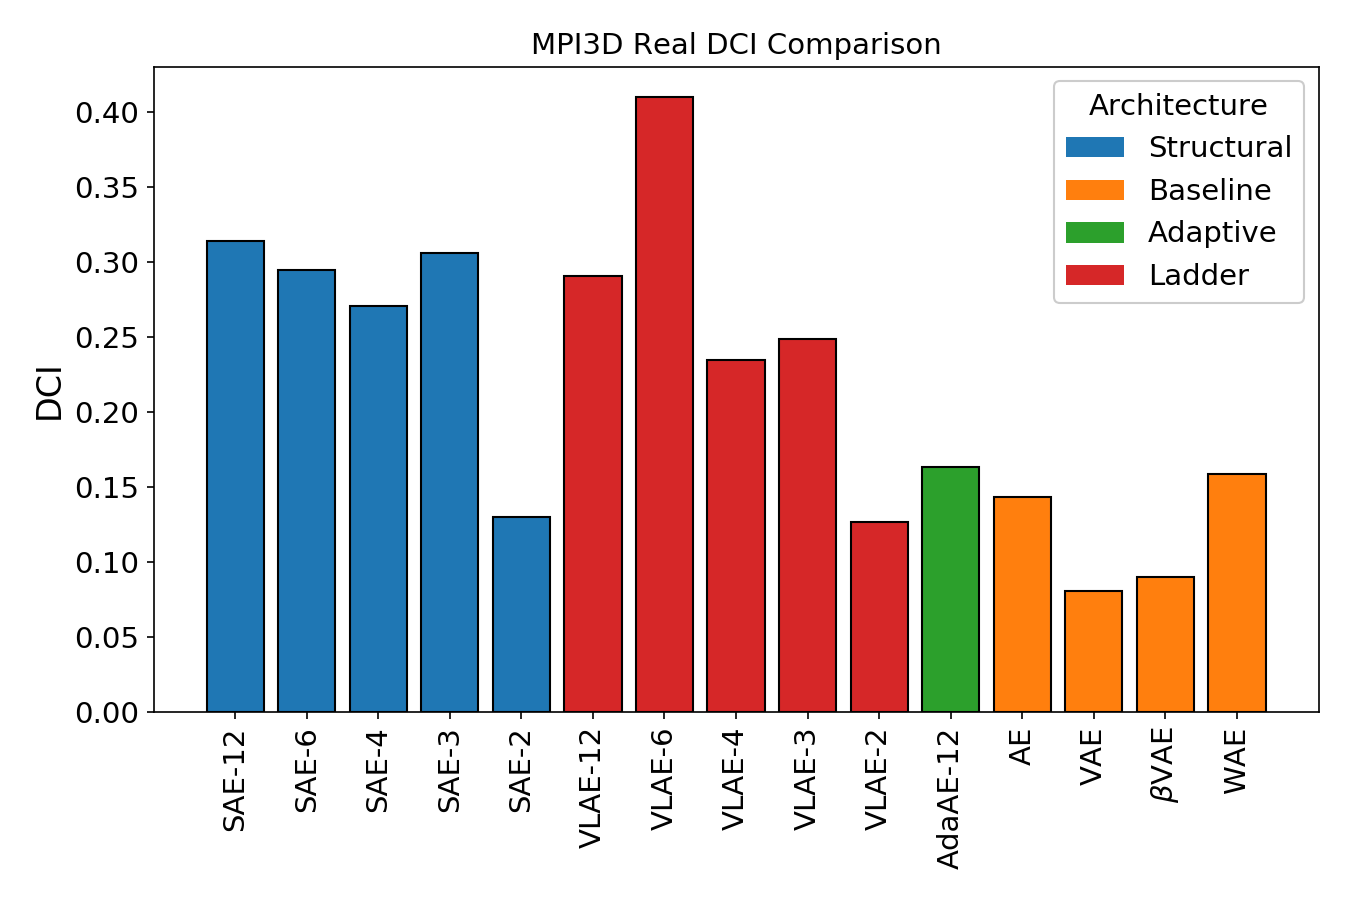

<IPython.core.display.Javascript object>


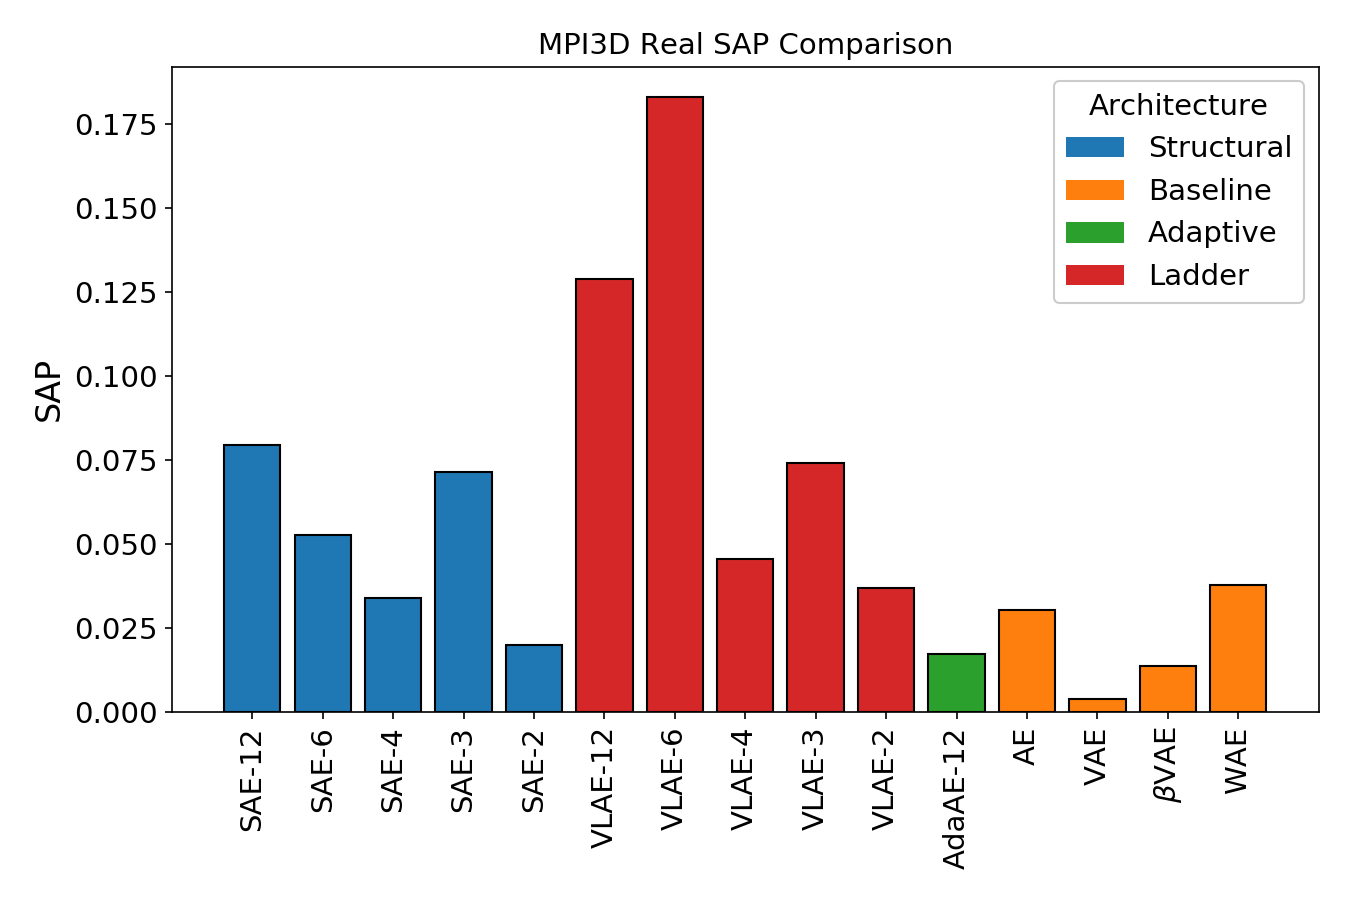

<IPython.core.display.Javascript object>


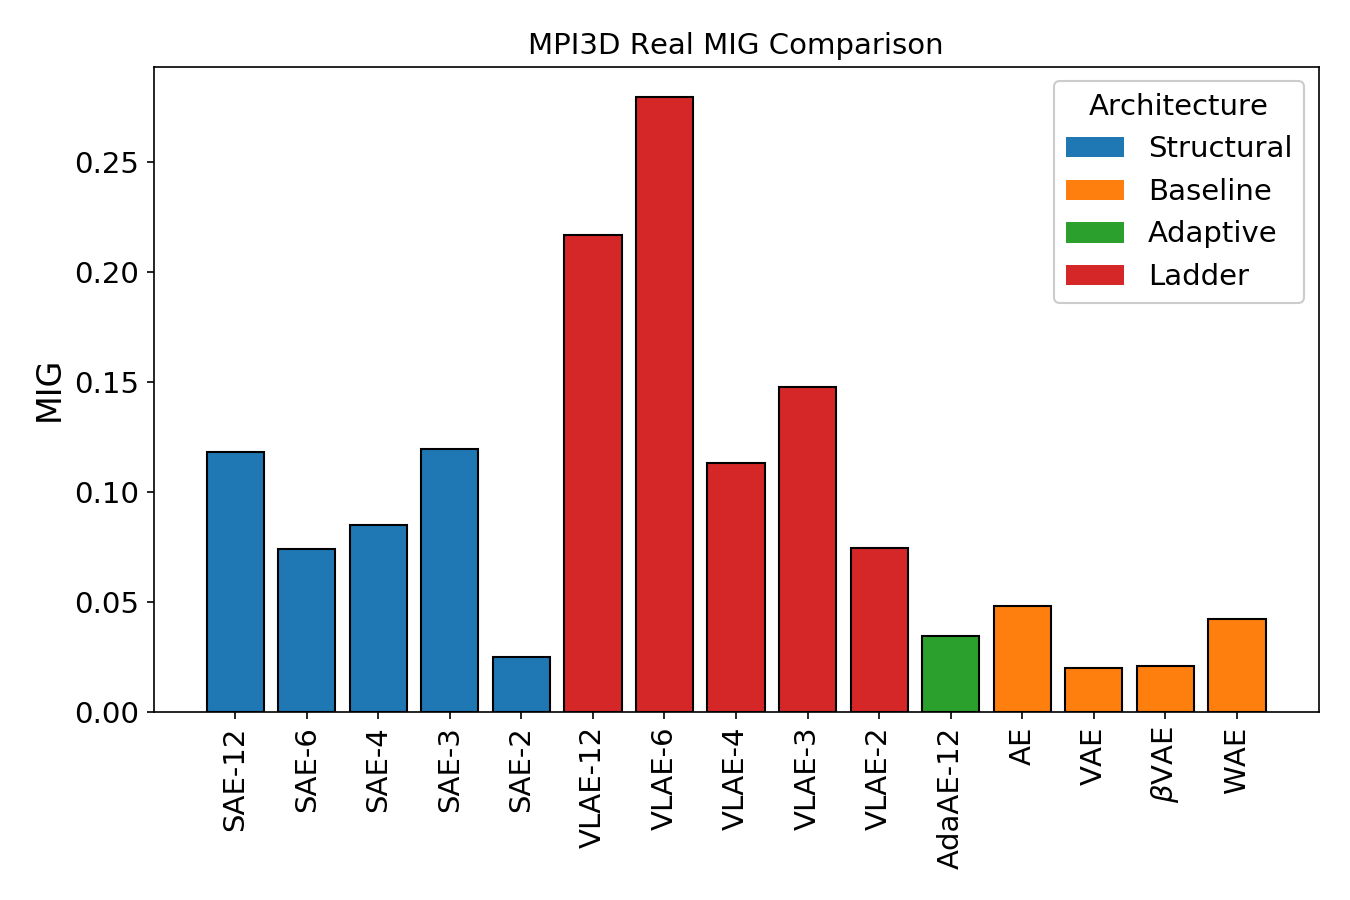

<IPython.core.display.Javascript object>


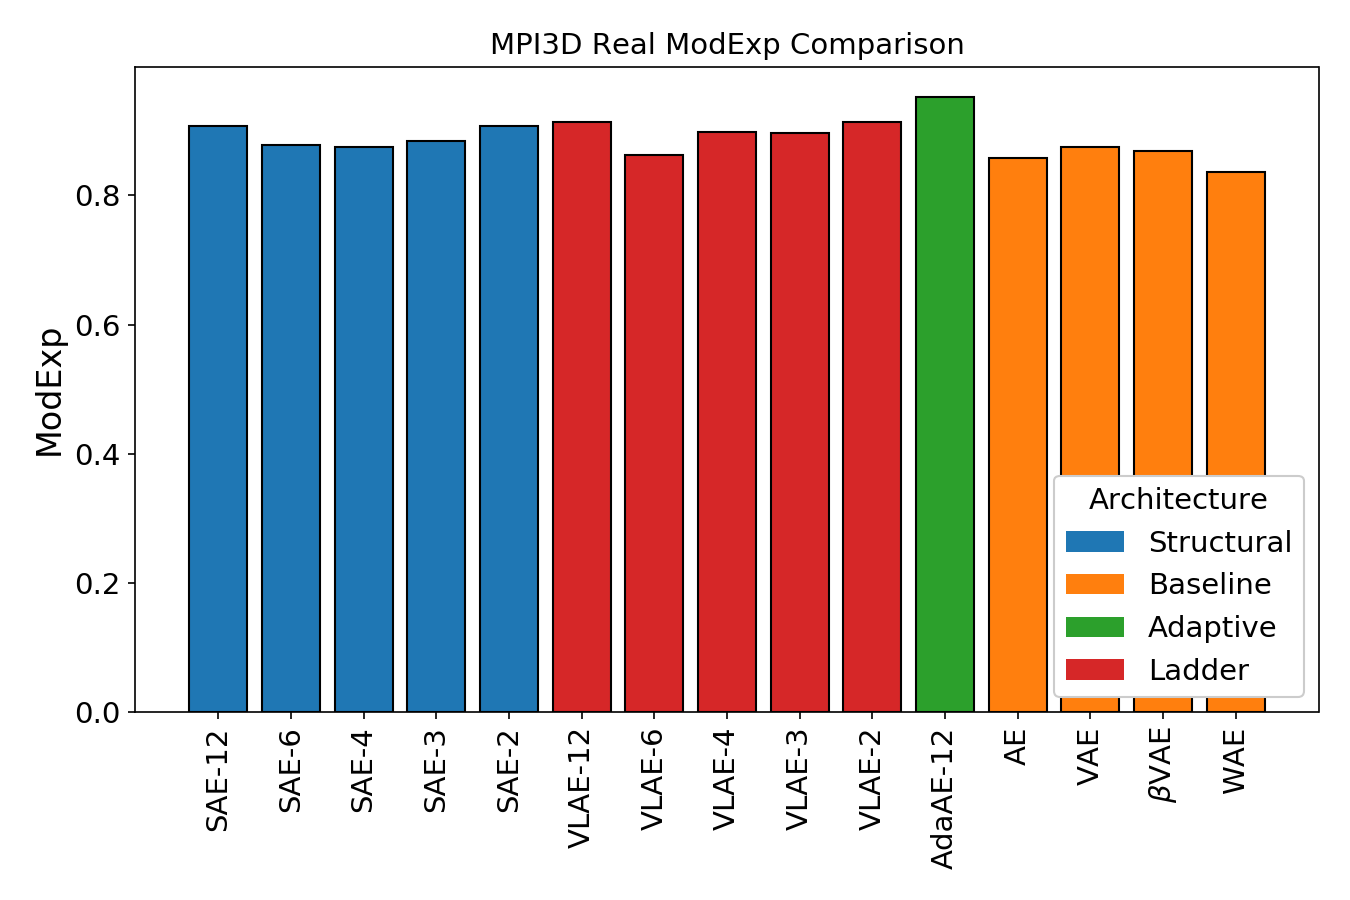

<IPython.core.display.Javascript object>


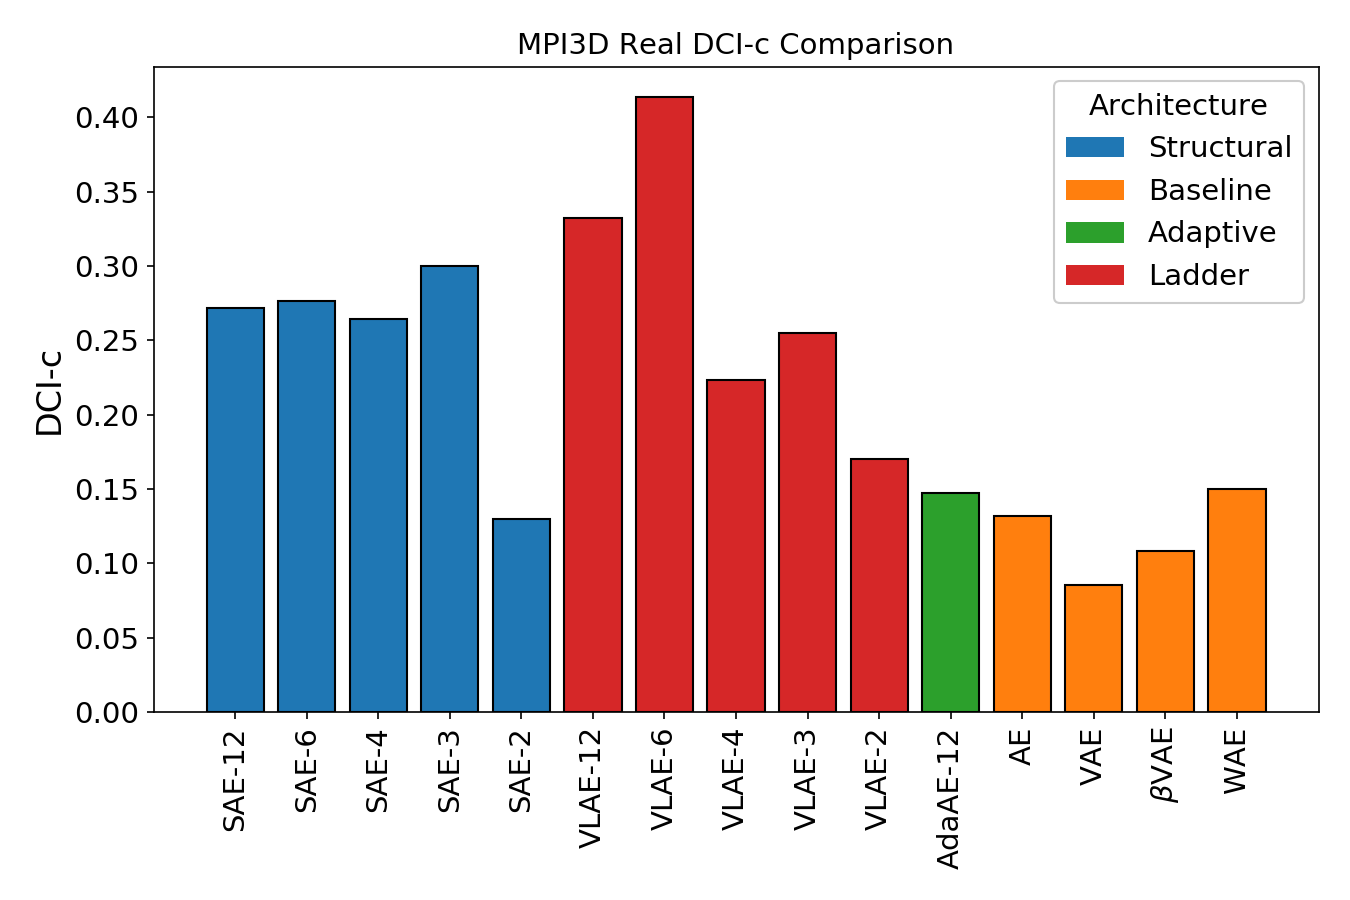

In [90]:
for pick in picks:
    fig, ax = plt.subplots(figsize=info.fsize)
    x = np.arange(len(title_order))
    mu = 0
    mx = None
    for i,t in enumerate(title_order):
        r = run_idents[t]
        s = r.stats[pick]
        if mx is None or s > mx:
            mx = s
        mu += s
        c = info.colors[r.group]
        plt.bar(i, s, color=c, edgecolor='k', )
    plt.xticks(x, [titles[t] for t in title_order], rotation='vertical')
    mu /= len(title_order)
    
    legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(info.group_names)]
#     legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
    
    legend = plt.legend(handles=legend_elements, loc=(4 if 2*mx/3 < mu else 1), title='Architecture',  framealpha=1)

    # plt.xlabel('Reconstruction Loss')
    plt.ylabel(f'{pick}')
    plt.title(f'{info.title} {pick} Comparison')
    plt.tight_layout()
#     util.save_figure(f'{dscode}_{pick}', **save_figure_kwargs)
    pass

In [67]:
run.data.keys()

odict_keys(['IRS', 'cov', 'SAP', 'DCI', 'Response', 'FactorResponse'])

In [101]:
mat_name = 'FactorResponse'
# mat_name = 'Response'
# mat_name = 'DCI'

In [102]:
allRs = {r.ident:r.data[mat_name] for r in runs if hasattr(r, 'data')}
if mat_name == 'FactorResponse':
    allRs = {k: v.min(1)[0].max(-1)[0] for k,v in allRs.items()}
if mat_name in {'DCI', 'IRS', 'SAP'}:
    allRs = {k: v.T for k,v in allRs.items()}

allRs.keys()

dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S2', 'AE S3', 'AE S4', 'AE S6', 'AE S12', 'AE S12 nosplit', 'VAE1 L2', 'VAE1 L3', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12'])

In [103]:
factor_order = ['object_color', 'object_shape', 'object_size', 'camera_height', 'background_color',
		                     'horizonal_axis', 'vertical_axis'] if dscode in {'toy', 'sim',  'real'} else ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
factors = {'floor_hue': 'Floor Hue', 'wall_hue': 'Wall Hue', 'object_hue': 'Object Hue', 'scale': 'Scale', 'shape': 'Shape', 'orientation': 'Orientation'}


In [104]:
nax = 15
H,W = util.calc_tiling(nax)
H,W

(3, 5)

<IPython.core.display.Javascript object>


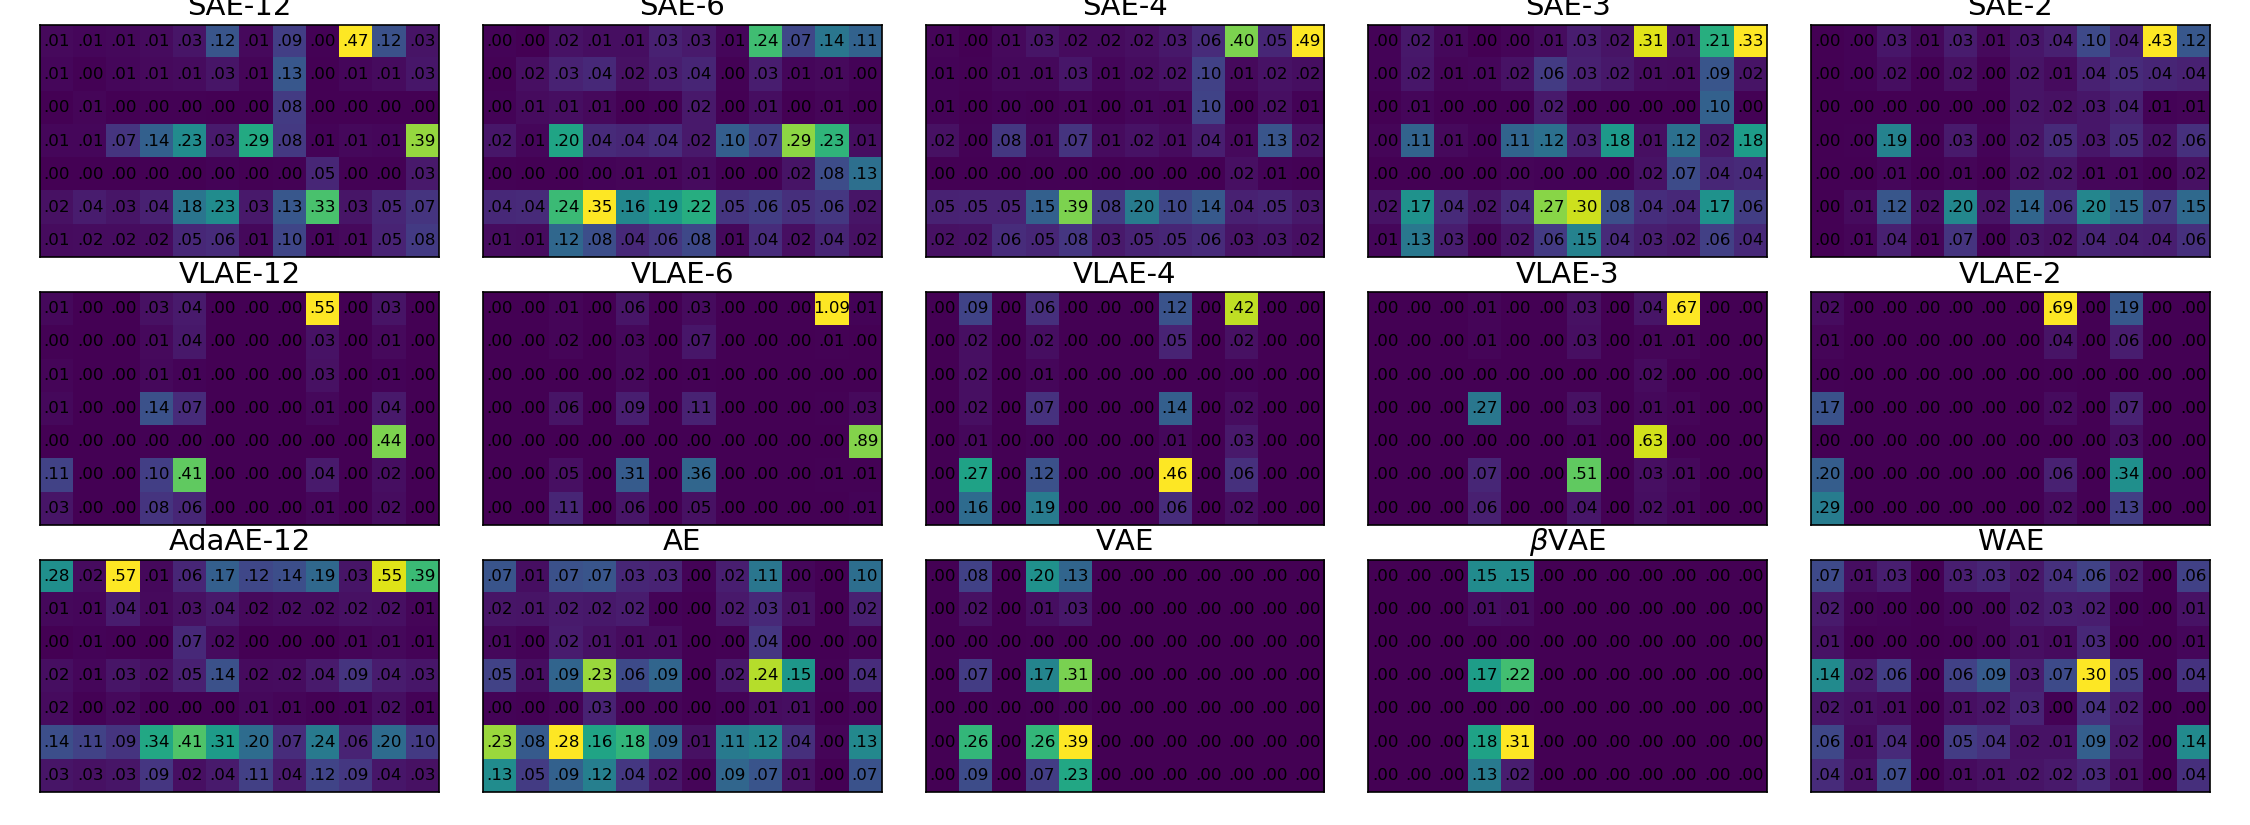

Figure real_FactorResponse_matrices saved as {'pdf', 'png'}


In [105]:
fg, axes = plt.subplots(H,W, figsize=(15,10) if mat_name == 'Response' else (15,5.5))
axes = axes.reshape(-1)

for ax, title in zip(axes, title_order):
    plt.sca(ax)
    
    Rs = allRs[title]
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(Rs, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(run_idents[title].title, pad=-1)

    
for i in range(len(allRs), nax):
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.02, bottom=0.04, top=0.97, left=0.01, right=0.99)
util.save_figure(f'{dscode}_{mat_name}_matrices', **save_figure_kwargs)

In [14]:
M, F, R = run.data['Response'], run.data['FactorResponse'].min(1)[0].max(-1)[0], run.data['DCI'].T
M.shape, F.shape, R.shape

KeyError: 'FactorResponse'

<IPython.core.display.Javascript object>


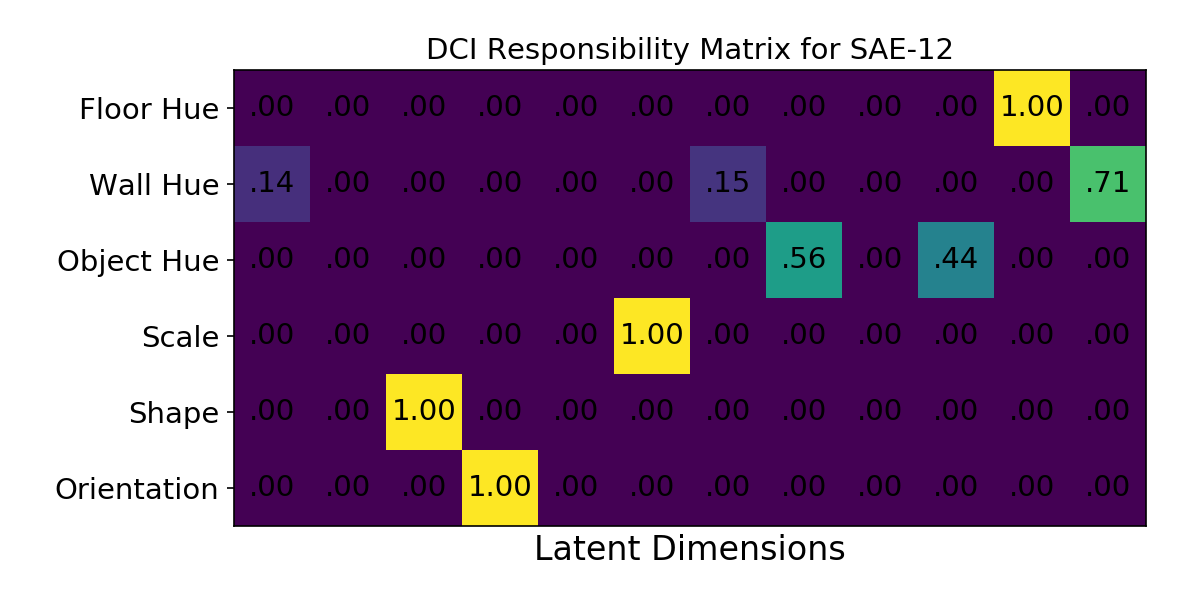

Figure 3ds_S12_dci-mat saved as {'png', 'pdf'}


In [19]:
fg, ax = plt.subplots(figsize=(8,4))
util.plot_mat(R, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':14}, figax=(fg,ax))
plt.xticks([])
plt.yticks(np.arange(len(factor_order)), [factors[f] for f in factor_order])
plt.title(f'DCI Responsibility Matrix for {run.title}', pad=-6)
plt.xlabel('Latent Dimensions')
plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_dci-mat', **save_figure_kwargs)
pass

In [23]:
M = run.data['Response']

AttributeError: 'Inline_Timed_SAE_Run' object has no attribute 'data'

<IPython.core.display.Javascript object>


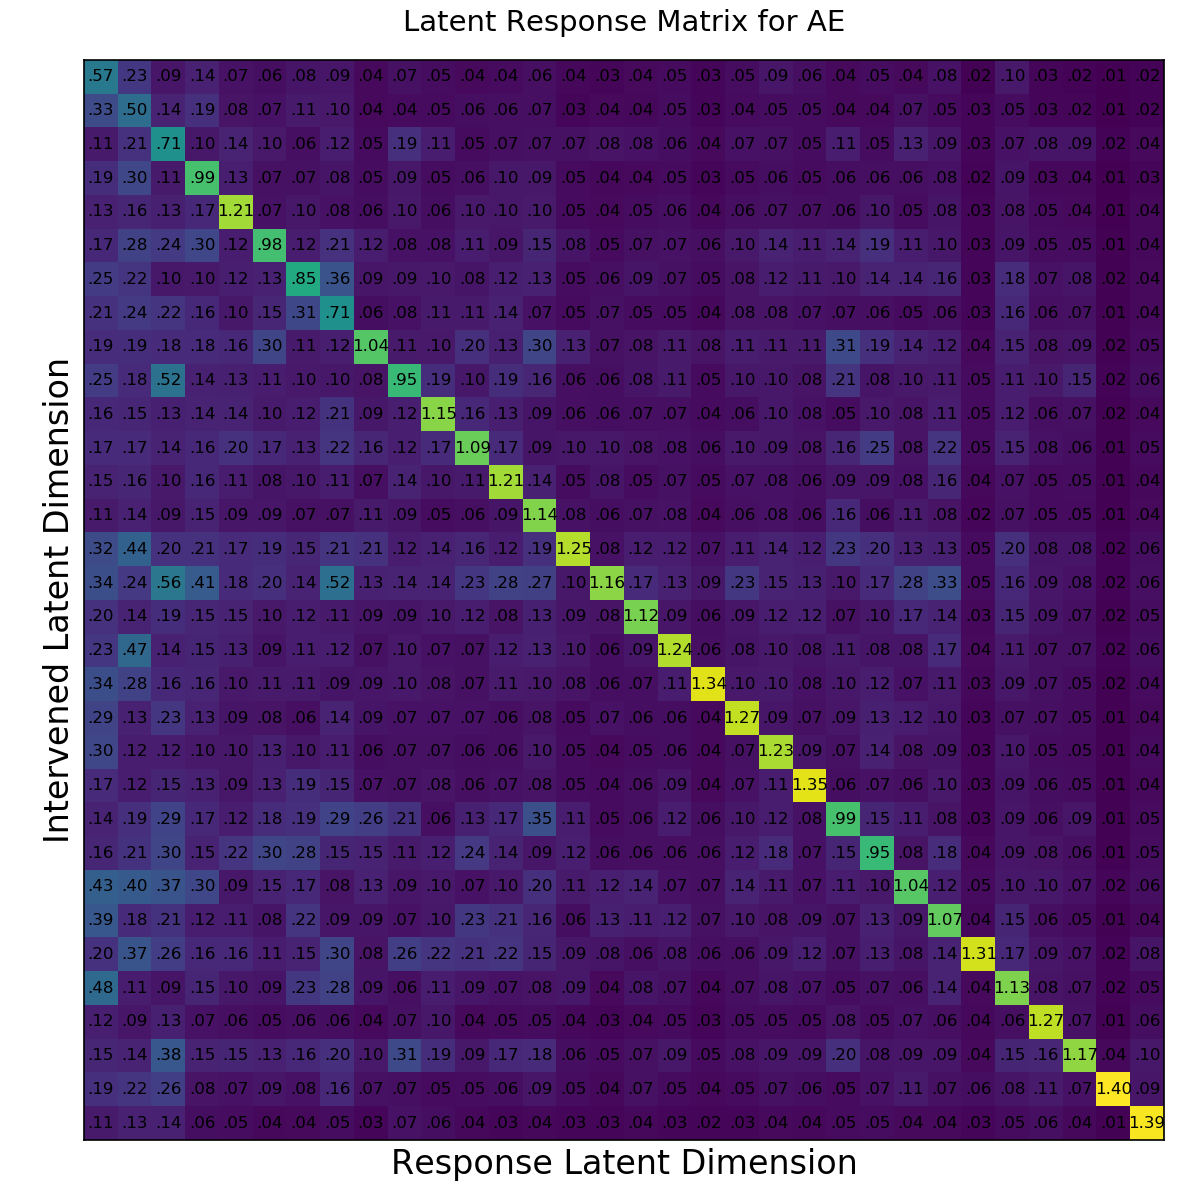

Figure celeb_AE_response-mat saved as {'png', 'pdf'}


In [21]:
fg, ax = plt.subplots(figsize=(8,8))
util.plot_mat(M, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':8}, figax=(fg,ax))
plt.xticks([])
plt.yticks([])
# ax.xaxis.set_label_position('bottom') 
plt.title(f'Latent Response Matrix for {run.title}', pad=-12)
plt.xlabel('Response Latent Dimension')
plt.ylabel('Intervened Latent Dimension')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02, bottom=0.05, top=0.95, left=0.05, right=0.99)
util.save_figure(f'{dscode}_{run.code}_response-mat', **save_figure_kwargs)
pass

<IPython.core.display.Javascript object>


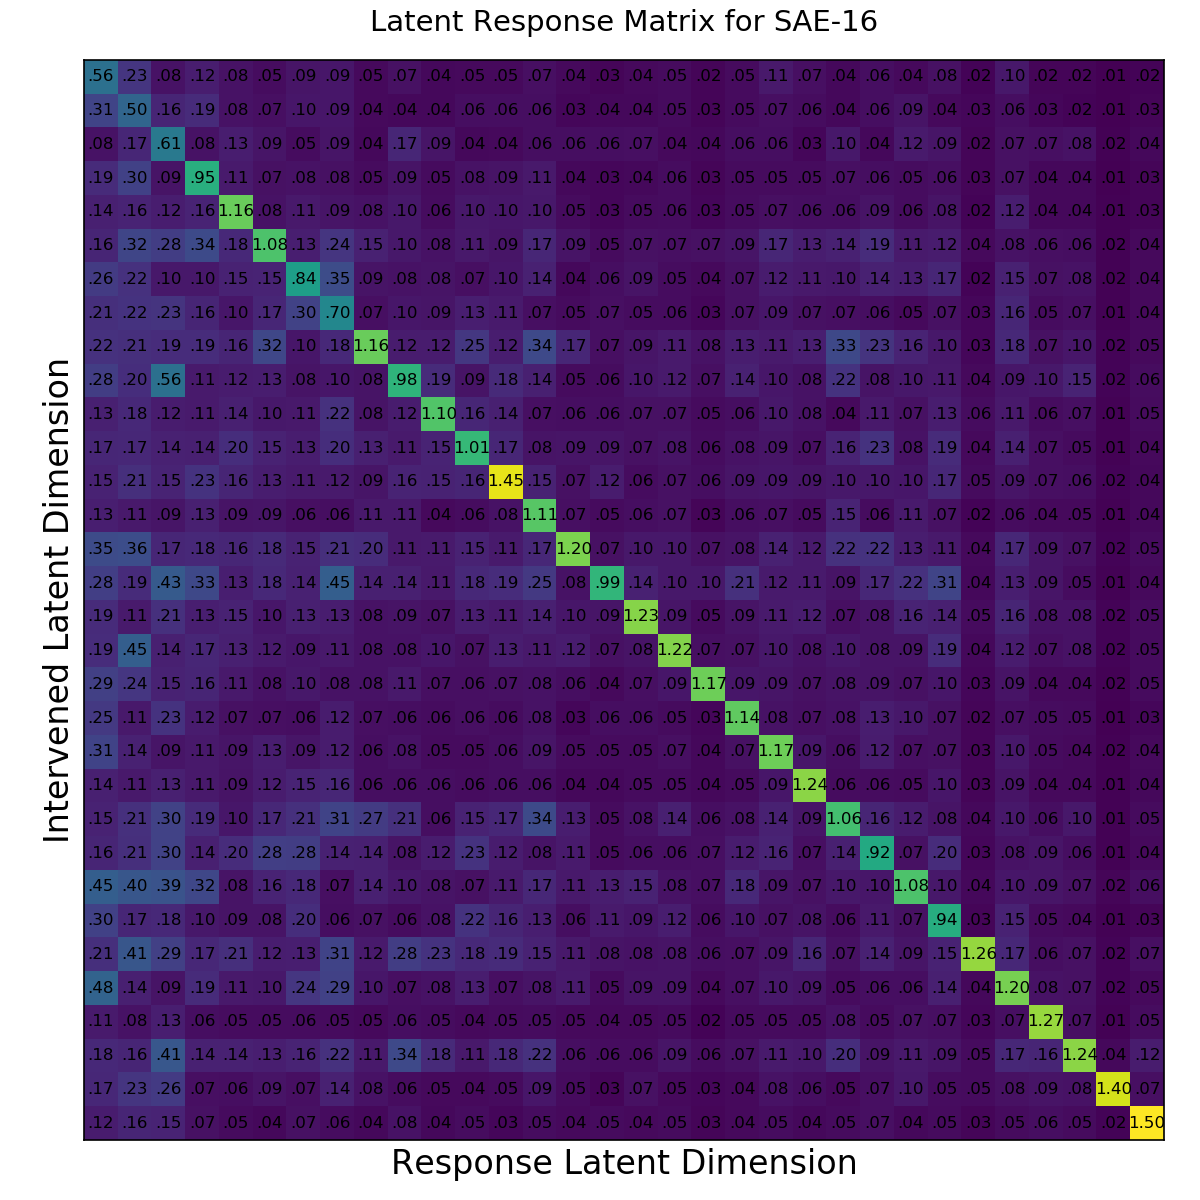

In [33]:
fg, ax = plt.subplots(figsize=(8,8))
util.plot_mat(M, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':8}, figax=(fg,ax))
plt.xticks([])
plt.yticks([])
# ax.xaxis.set_label_position('bottom') 
plt.title(f'Latent Response Matrix for {run.title}', pad=-12)
plt.xlabel('Response Latent Dimension')
plt.ylabel('Intervened Latent Dimension')
# plt.tight_layout()
plt.subplots_adjust(hspace=0.02, wspace=0.02, bottom=0.05, top=0.95, left=0.05, right=0.99)
# util.save_figure(f'{dscode}_{run.code}_response-mat', **save_figure_kwargs)
pass

<IPython.core.display.Javascript object>


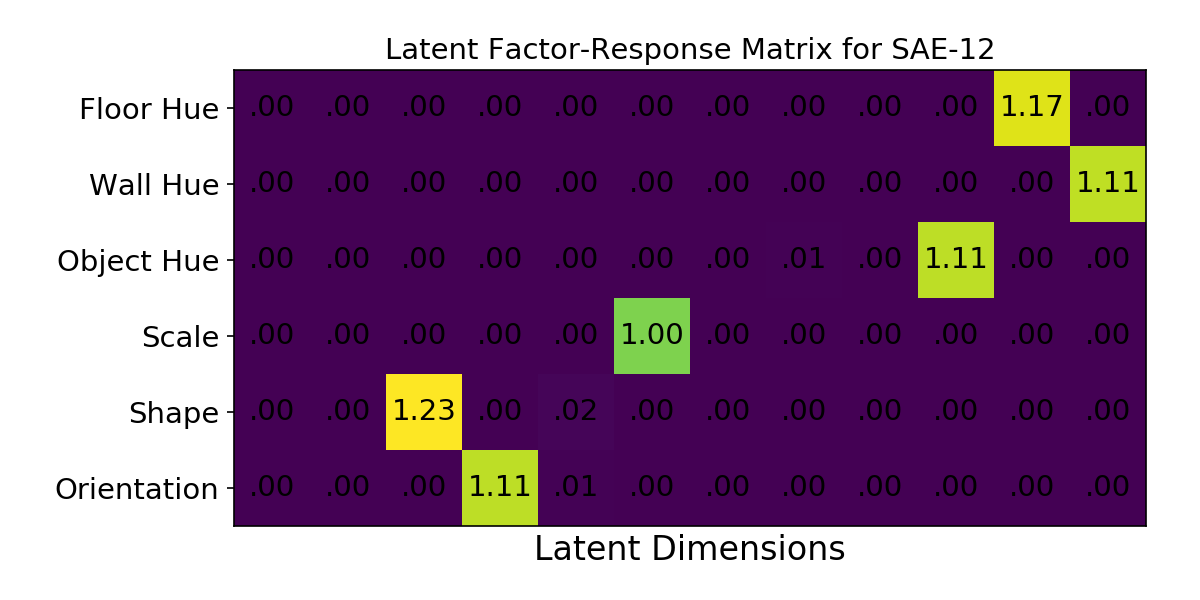

Figure 3ds_S12_factor-mat saved as {'png', 'pdf'}


In [21]:
fg, ax = plt.subplots(figsize=(8,4))
util.plot_mat(F, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), text_kwargs={'size':14}, figax=(fg,ax))
plt.xticks([])
plt.yticks(np.arange(len(factor_order)), [factors[f] for f in factor_order])
plt.title(f'Latent Factor-Response Matrix for {run.title}', pad=-6)
plt.xlabel('Latent Dimensions')
plt.tight_layout()
util.save_figure(f'{dscode}_{run.code}_factor-mat', **save_figure_kwargs)
pass

In [109]:
from copy import deepcopy
from tabulate import tabulate

In [108]:
tbl = deepcopy(full_table)
tbl.keys()

dict_keys(['3ds', 'sim', 'toy', 'real'])

In [166]:
dstitles = {'3ds':'3D-Shapes', 'toy':'MPI3D Toy', 'sim':'MPI3D Sim', 'real':'MPI3D Real'}
picktitles = {'CDS':'CDS', 'DCI':'DCI-d', 'IRS':'IRS', 'MIG':'MIG', 'SAP':'SAP', 'ModExp':'ModExp', 'CCS':'CCS', 'DCI-c':'DCI-c'}
len(title_order), title_order

(15,
 ['AE S12',
  'AE S6',
  'AE S4',
  'AE S3',
  'AE S2',
  'VAE1 L12',
  'VAE1 L6',
  'VAE1 L4',
  'VAE1 L3',
  'VAE1 L2',
  'AE S12 nosplit',
  'AE',
  'VAE1',
  'VAE2',
  'WAE10'])

In [118]:
picks

['CDS', 'CCS', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp', 'DCI-c']

In [181]:
pick_order = ['CDS', 'DCI', 'IRS', 'MIG', 'SAP', 'ModExp', 'CCS', 'DCI-c']
# pick_order = ['CDS', 'DCI', 'IRS', 'MIG', 'SAP', 'CCS', 'DCI-c']
ds_order = ['3ds', 'toy', 'sim', 'real']

In [182]:
import pickle

In [183]:
from itertools import product

In [184]:
# pickle.dump(full_table, open('figures/table.pkl', 'wb'))

In [185]:
r1 = {a:{b:[d[t] for t in title_order] for b,d in vs.items()} for a,vs in tbl.items()}
r2 = {a:[d[p] for p in pick_order] for a, d in r1.items()}
r3 = [r2[d] for d in ds_order]

In [186]:
full = np.array(r3)
full = full.transpose(2,1,0)
A, M, D = full.shape
full.shape

(15, 8, 4)

In [187]:
headers = ['Name'] + [f'{d}-{p}' for d, p in product(ds_order, pick_order)]
headers = ['Model'] + [f'{picktitles[p]}' for d, p in product(ds_order, pick_order)]

len(headers)

33

In [201]:
# T = full.reshape(A, -1)
T = full[...,3]
bx, by = np.arange(T.shape[-1]), T.argmax(0)
ismx = np.zeros(T.shape).astype(int)
ismx[by,bx] = 1
sp = T.shape
T = np.array([r'{}\bf {:.3f}{}'.format('{', t,'}') if bold else f'{t:.3f}' for t, bold in zip(T.reshape(-1),ismx.reshape(-1))])
T = T.reshape(*sp)
f2 = np.concatenate([np.array([titles[t] for t in title_order]).reshape(-1,1), T],-1)
T = f2.tolist()
f2.shape

(15, 9)

In [202]:
# print(tabulate(T, headers=headers))

In [203]:
print(tabulate(T, headers=headers, tablefmt='latex_raw'))

\begin{tabular}{lllllllll}
\hline
 Model      & CDS         & DCI-d       & IRS         & MIG         & SAP         & ModExp      & CCS         & DCI-c       \\
\hline
 SAE-12     & 0.506       & 0.314       & 0.543       & 0.118       & 0.079       & 0.908       & 0.308       & 0.272       \\
 SAE-6      & 0.433       & 0.295       & 0.535       & 0.074       & 0.053       & 0.879       & 0.208       & 0.277       \\
 SAE-4      & 0.510       & 0.270       & 0.523       & 0.085       & 0.034       & 0.876       & 0.273       & 0.264       \\
 SAE-3      & 0.398       & 0.306       & 0.495       & 0.119       & 0.072       & 0.884       & 0.221       & 0.300       \\
 SAE-2      & 0.395       & 0.130       & 0.527       & 0.025       & 0.020       & 0.908       & 0.245       & 0.130       \\
 VLAE-12    & 0.633       & 0.291       & 0.579       & 0.217       & 0.129       & 0.914       & 0.673       & 0.332       \\
 VLAE-6     & 0.754       & {\bf 0.410} & {\bf 0.668} & {\bf 0.279} & 

In [25]:
len(runs)

6

In [27]:
run.info

{'arch_type': 'c16',
 'dataset_type': 'celeba',
 'dec_type': 'c16',
 'enc_type': 'c16',
 'extra': 'mish',
 'model_type': 'vae',
 'size': 128}

In [30]:
num = 32

In [31]:

def _load_gen(run):
    model = run.get_model()
    with torch.no_grad():
        run.hgen = model.generate_hybrid(num)
        try:
            run.pgen = model.generate_prior(num)
        except AttributeError:
            run.pgen = None
runs.map(_load_gen, pbar=tqdm);


  0%|          | 0/6 [00:00<?, ?it/s]

Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2,

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_ae0_e-c16_d-c16_mish_210125-132401\ckpt200000


Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.


Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): MaxPool2d(kernel_size=(2, 

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_vae1_e-c16_d-c16_mish_210125-132401\ckpt200000
Hybrid_VAE(
  (encoder): Normal_MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
    

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_vae2_e-c16_d-c16_mish-lrp0003_210201-101817\ckpt200000
Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=F

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_ae0_e-c16_d-s16_mish_210125-132401\ckpt200000
Hybrid_Autoencoder(
  (encoder): MultiLayer(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (2): ConvLayer(
        residual=False
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (3): ConvLayer(
        residual=False
    

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401\ckpt200000
Hybrid_VAE(
  (encoder): Normal_LadderEncoder(
    (layers): ModuleList(
      (0): ConvLayer(
        residual=False
        (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
        (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
        (nonlin): Mish()
      )
      (1): InferenceRung(
        pool=max
        (net): MLP(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Mish()
          (2): Linear(in_features=256, out_features=128, bias=True)
          (3): Mish()
          (4): Linear(in_features=128, out_features=64, bias=True)
          (5): Mish()
          (6): Linear(in_features=64, out_features=4, bias=True)
        )
      )
      (2): ConvLayer(
        residual=False
        (conv): Con

Loaded parameters from C:\Users\anwan\Documents\workspace\sae\final\celeba_vae1_e-l16_d-l16_mish-lrp0004_210201-034237\ckpt160000


In [32]:
run.hgen.shape

torch.Size([32, 3, 128, 128])

In [45]:
cruns = {r.code: r for r in runs}
cruns.keys()

dict_keys(['AE', 'VAE', 'VAE2', 'S12', 'S12n', 'L12'])

In [93]:
picks = ['S12', 'S12n', 'L12', 'VAE']
sel = slice(4,10)
sel = slice(10,16)
sel = [10,11,5,14,15,19]

In [94]:
rnames = []
rows = []
for pick in picks:
    r = cruns[pick]
    if r.pgen is not None:
        rnames.append((r.title, 'Prior'))
        rows.append(r.pgen[sel])
    rnames.append((r.title, 'Hybrid'))
    rows.append(r.hgen[sel])
ims  = torch.cat(rows)
len(rnames), len(ims)

(6, 36)

In [95]:
H, W = len(rnames),len(ims)//len(rnames)
H,W

(6, 6)

<IPython.core.display.Javascript object>


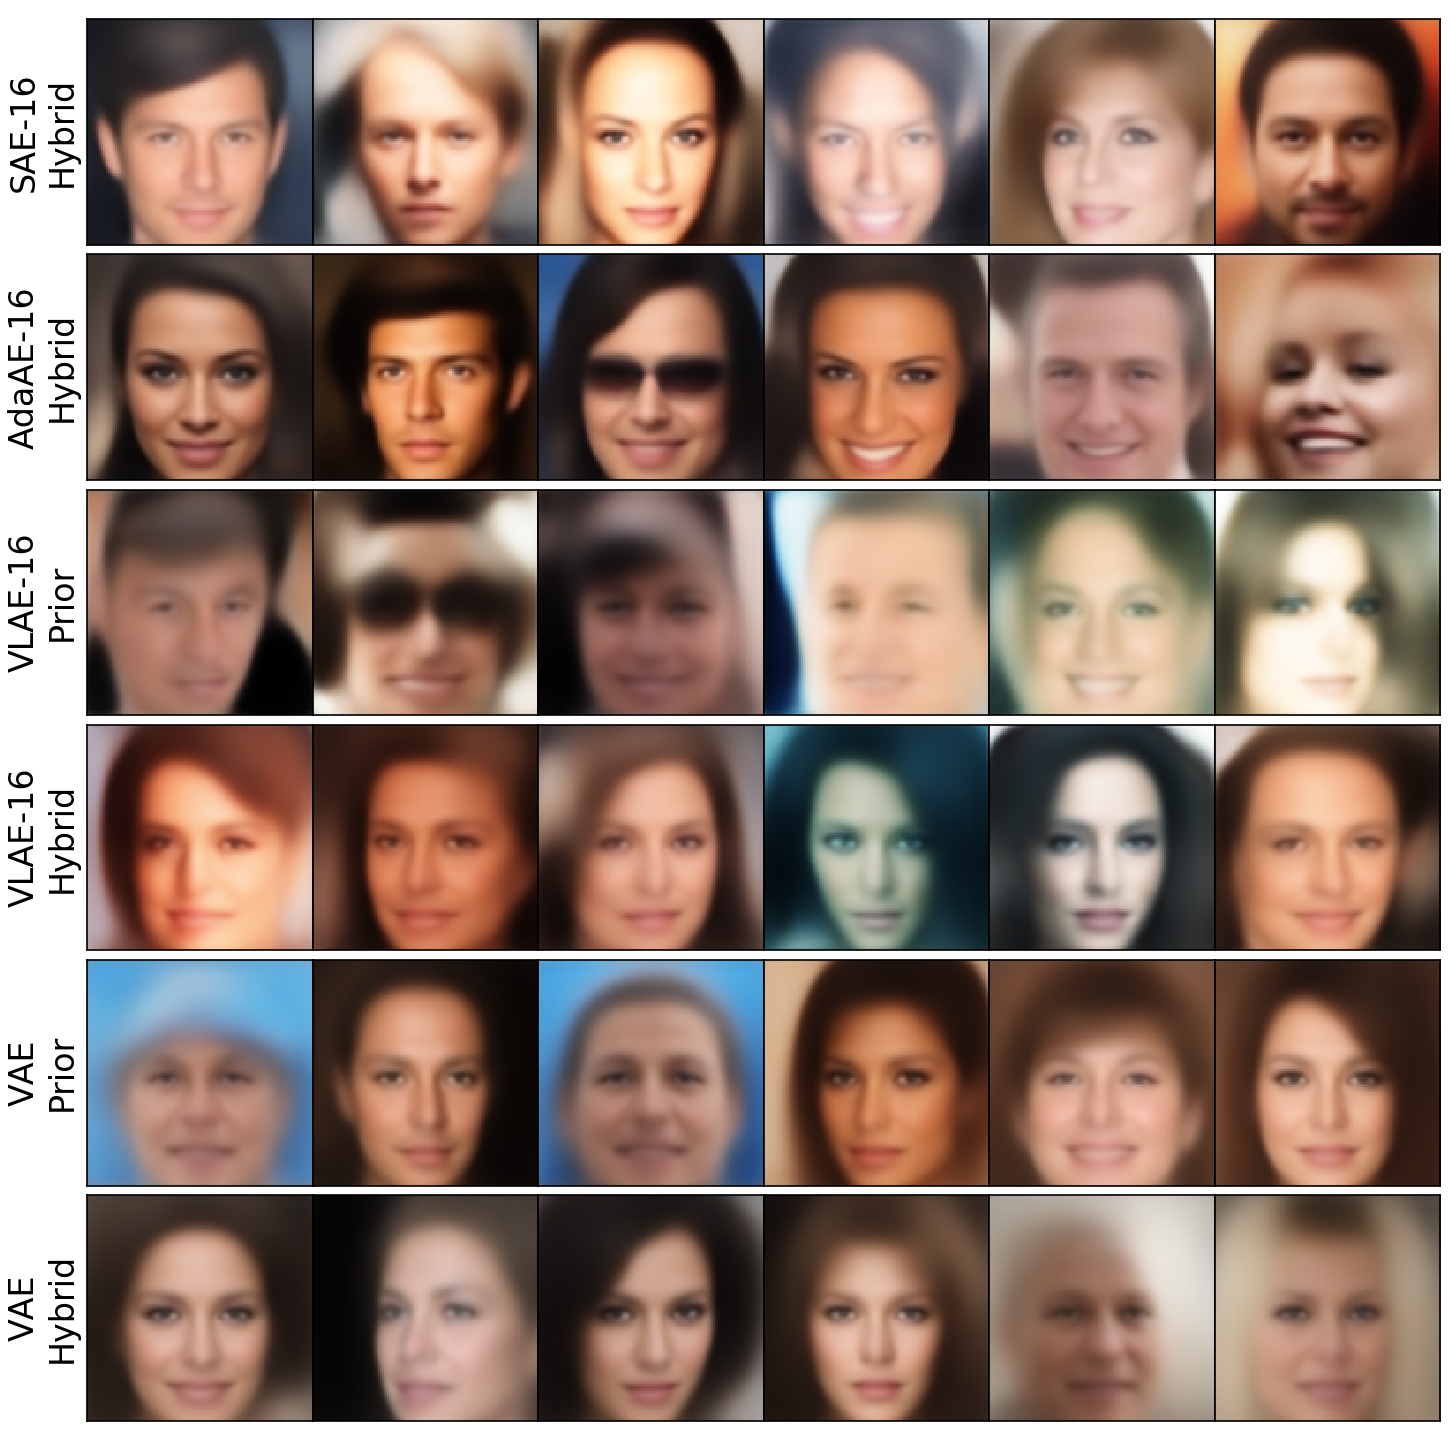

Figure celeba_samples_vae saved as {'pdf', 'png'}


In [96]:
side = 1.6
colnames = [None]*W
fg, axs = plt.subplots(H, W, figsize=(side*W+0.1,side*H))

imgs = ims.cpu().view(H, W, 3, 128, 128).permute(0,1,3,4,2).cpu().detach().numpy()

for i, (rax, (mname, sname), row) in enumerate(zip(axs, rnames, imgs)):
    
    for ax, col, im in zip(rax, colnames, row):
        plt.sca(ax)
        if i == 0 and col is not None:
            plt.title(col)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(im)
    plt.sca(rax[0])
    plt.ylabel(f'{mname}\n{sname}')
plt.subplots_adjust(hspace=0.0, wspace=0.0, bottom=0.01, top=0.99, left=0.06, right=0.99);

util.save_figure(f'celeba_samples_vae', **save_figure_kwargs)